# NOAA: Detecting SST Anomalies Using A Unsupervised Learning Approach

***Introduction***

The purpose of this notebook serves to further build on our learnings from the noaa_evaluation EDA and attempt to train unsupervised models where we will cross validate the results against our random forest regressor using a time-series structure in hopes to build even further and increase teh accuracy of our model. 

We aim to do this by making a comparative analysis between the timestamps of SST anomalies and the prediction results from our Random Forest Regressor that will be tested on the NOAA dataset. This notebook is going to solely focus onto SST anomaly detections and create an anomaly detector model of it's own.

Please keep in mind that the noaa_evaluation notebook can be looked at as a mandatory pre-requisite to this part of our findings as we build on the fundamental learnings and results.

***Contents***

For the contents of this notebook, we can break it down into three main sections EDA Revision & Extended Analysis, Feature Engineering, Unsupervised Model Training, Cross-Validation to RFR:

- EDA Revision & Extended Analysis: In this sub-section we will do a quick recap of notebook 1 and it's most relevant parts. We will then logically follow with a deepened time-series analysis relevant to SST anomalies

- Feature Engineering: This section builds the necessary feature variables that are used throughout the unsupervised training

- Unsupervised Training: This section covers the selection and training of our unsupervised model where we will attempt to accurately detect SST anomalies

- Cross-Validation of Models: This section builds on the previous sections model where we shall cross validate it's results with our Random Forest Regressor and test it's predictive accuracy to further improve our models strength and accuracy


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN

Firstly, let's read the dataset that we pulled and combined for multiple regions and stations in our Multi-Set Analysis (Section 2). This has already be ran through the mini data transformation pipeline that we wrote, so the Season and Date columns are already appended together with the appropriate data type castings:

In [49]:
combined_regional_df = pd.read_csv('../../data/noaa/pulled_data/coral_reef_data_combined.csv')

print('Number of rows:', len(combined_regional_df))
print(combined_regional_df.describe())
print(combined_regional_df.dtypes)

Number of rows: 177043
                YYYY             MM             DD       SST_MIN  \
count  177043.000000  177043.000000  177043.000000  177043.00000   
mean     2004.700525       6.487887      15.722932      26.78480   
std        11.662090       3.452751       8.797549       1.96167   
min      1985.000000       1.000000       1.000000      17.09000   
25%      1995.000000       3.000000       8.000000      25.65000   
50%      2005.000000       6.000000      16.000000      27.23000   
75%      2015.000000       9.000000      23.000000      28.24000   
max      2025.000000      12.000000      31.000000      31.44000   

             SST_MAX    SST@90th_HS   SSTA@90th_HS      90th_HS>0  \
count  177043.000000  177043.000000  177043.000000  177043.000000   
mean       28.117110      27.775844       0.533198       0.187283   
std         1.601725       1.627570       0.623586       0.373325   
min        21.400000      21.240000      -2.350300       0.000000   
25%        27.11000

## Section 1: EDA Revision & Extended Analysis

### Sub Sections:

- Sub-section 1.1: EDA Revision

- Sub-section 1.2: Deeper Time-Series Analysis

### Sub-section 1.1: EDA Revision

***EDA Recap***

Just to give a short recap to what we discovered in our previous findings, if we recall to the Single-Set Anlaysis and particularly our discoveries within the sub-section 1.3 of our distdistributionribtuion analysis, you will see that we found a normal distribution when analysing the SSTA@90th_HS>0. 

We logically built on that finding by mapping the seasonal fluctuations via grouping the columns by seasons then re-plotting the distributions from each season in the subsequent sub-section 1.4. It was from this analysis that we were able to conclude that the SST anomaly distribution was in fact ***not*** influenced by seasonal changes. 

Another key insight and derived data that we were able to retrieve from this section can be seen in sub-section 1.5 where we made a time-series analysis and pinpointed the exact time delays measured in days for the maximum correlation that these results had with when mapped to the BAA severity levels. We will also be leveraging these results and building the majority of the next sub-section from this finding.

***Building on Those Concepts***

It is within this section that we can truly leverage the findings from sub-section 1.4 and 1.5 by building on the concept and trying to engineer ourselves a model that will help detect SST anomalies before they even happen. 

The target of this build is to not only further strengthen the conclusions drawn for our prior analysis, but to also build an extended model that will allow individuals and scientists to predict SST anomalies before they occur, ultimately creating an early warning system for potential SST anomalies with hopes to be married 
together with our RFR prediction model from previous notebook.

Before we dive into the feature engineering of our unsupervised learning model, we need to particularly revisit a single part of our EDA analysis from the first notebook. This is will be the time-series analysis from subsections 1.5 and 2.5. We must do this as it is the pinnacle for the model.

### Sub-section 1.2: Deep Time-Series Analysis

Within this revisit, we will be taking a deeper dive into the time-series lags for the correlations that the values have with not only the BAA severity levels, but with each other. 

As we will be focusing particularly onto the SST anomalies within this section, we would like to do a deepened time-series analysis with a particular aim to detect any patterens within the SST Anomalies


***Rolling Window Analysis***

We can get started by doing a rolling window analysis. Please find the reference here: [MATLAB Rolling Window](https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html)

As said in the MATLAB's example, we can need to define the rolling window. Since we are working over a fairly long time-period, I would like to follow their advice of: "In general, you can use a short rolling window size for data collected in short intervals, and a larger size for data collected in longer intervals". Therefore lets go with the window size 30 days for month segments to begin with. First lets sort the rows by date to ensure we have the correct timeline. I also want to index the Date column for faster queries and ease:

In [50]:
combined_regional_df = combined_regional_df.sort_values('Date')
combined_regional_df.set_index('Date', inplace=True)

print(combined_regional_df.head())

            YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  \
Date                                                                    
1985-01-01  1985   1   1    28.82    29.25        29.03        0.7797   
1985-01-01  1985   1   1    28.30    29.03        28.69        0.5165   
1985-01-01  1985   1   1    28.22    28.84        28.73        0.0039   
1985-01-01  1985   1   1    24.13    24.70        24.32       -0.3071   
1985-01-01  1985   1   1    25.76    27.85        27.54        0.2771   

            90th_HS>0  DHW_from_90th_HS>1  BAA_7day_max  \
Date                                                      
1985-01-01       0.56                 0.0             0   
1985-01-01       0.13                 0.0             0   
1985-01-01       0.00                 0.0             0   
1985-01-01       0.00                 0.0             0   
1985-01-01       0.00                 0.0             0   

                          Station              Region  Latitude  Longitude

Data is in ascending order now, let's set the window size to 30 days as we determined above:

In [51]:
window_size = 30

Calculate the mean and the standard deviation to begin with using the 30 day segment window size:

In [52]:
combined_regional_df['SSTA_rolling_mean'] = combined_regional_df['SSTA@90th_HS'].rolling(window=window_size).mean()
combined_regional_df['SSTA_rolling_std'] = combined_regional_df['SSTA@90th_HS'].rolling(window=window_size).std()

print(combined_regional_df[['SSTA@90th_HS', 'SSTA_rolling_mean', 'SSTA_rolling_std']].head(40)) # I check for 40 because the first 29 rows will likely be NaN because of the window size

            SSTA@90th_HS  SSTA_rolling_mean  SSTA_rolling_std
Date                                                         
1985-01-01        0.7797                NaN               NaN
1985-01-01        0.5165                NaN               NaN
1985-01-01        0.0039                NaN               NaN
1985-01-01       -0.3071                NaN               NaN
1985-01-01        0.2771                NaN               NaN
1985-01-01       -0.5255                NaN               NaN
1985-01-01       -0.3077                NaN               NaN
1985-01-01        0.0552                NaN               NaN
1985-01-01       -0.1884                NaN               NaN
1985-01-01        0.2116                NaN               NaN
1985-01-01        0.6171                NaN               NaN
1985-01-01        0.1297                NaN               NaN
1985-01-02        0.0352                NaN               NaN
1985-01-02       -0.4571                NaN               NaN
1985-01-

As expected, we have NaN for the first 29 rows, but the other rows have properly calculated values. This is expected because the calculation requires the full window length!

We can quickly drop those NaN values:

In [53]:
length_before_drop = len(combined_regional_df)
combined_regional_df = combined_regional_df.dropna(subset=['SSTA_rolling_mean', 'SSTA_rolling_std'])
length_after_drop = len(combined_regional_df)

print(f'Dropped {length_before_drop - length_after_drop} rows for the NaN')
print(combined_regional_df[['SSTA@90th_HS', 'SSTA_rolling_mean', 'SSTA_rolling_std']].head()) 

Dropped 29 rows for the NaN
            SSTA@90th_HS  SSTA_rolling_mean  SSTA_rolling_std
Date                                                         
1985-01-03        0.3132           0.092740          0.405322
1985-01-03       -0.2174           0.059503          0.387539
1985-01-03       -0.5723           0.023210          0.394192
1985-01-03        0.1529           0.028177          0.394878
1985-01-03       -0.3471           0.026843          0.396115


As recalled from the sub-section 1.4 in the noaa_evaluation under the single-set analysis, we already have the knowledge that the distribution for the SSTA was in fact a normal distribution. This means that ofcourse, we can use the +/- 2 standard deviations rule. This basically tells us that 95% of all the data points are within +/- 2 standard deviations from the mean:

In [54]:
upper_threshold = combined_regional_df['SSTA_rolling_mean'] + 2 * combined_regional_df['SSTA_rolling_std']
lower_threshold = combined_regional_df['SSTA_rolling_mean'] - 2 * combined_regional_df['SSTA_rolling_std']

***Plot***

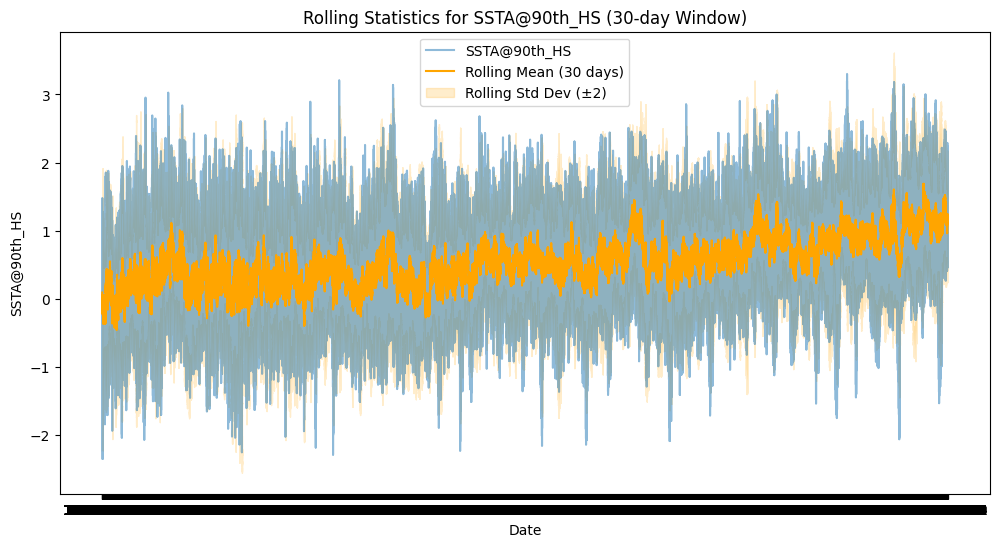

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(combined_regional_df.index, combined_regional_df['SSTA@90th_HS'], label='SSTA@90th_HS', alpha=0.5)
plt.plot(combined_regional_df.index, combined_regional_df['SSTA_rolling_mean'], label='Rolling Mean (30 days)', color='orange')
plt.fill_between(combined_regional_df.index, lower_threshold, upper_threshold, color='orange', alpha=0.2, label='Rolling Std Dev (±2)')
plt.title('Rolling Statistics for SSTA@90th_HS (30-day Window)')
plt.xlabel('Date')
plt.ylabel('SSTA@90th_HS')
plt.legend()
plt.show()

***Interpretation & Takeways***

- **Blue (SSTA@90th_HS)**: This blue line shows us the original time-series data for the SST anomalies, i.e. the raw values for the SSTA@90th_HS. This seems to show relatively stable over the past years from 1985 - 2025

- **Orange (Rolling Mean(30 days))**: This orange line represents the mean value from the rolling window. We find this useful fo seeing the true trend over the past years. Here we can interestingly see that the mean seems to very interestingly increase over the time period in a positive direction which we can deduce as likely seeing more anomaly spikes in within the recent years.

- **Yellow (Rolling Std Dev(+/-2))**: Remember this is the SD of +/- 2 from the mean so it is showing us the anomalies that is captured in 95% of raw SSTA values. This basically gives us the visiuals on the volatility of the SST anomalies over time. Here we also seem to see an upward trend in the recent years.

- **Anomalies (Implicitly Derived)**: This can be looked at as the values from the raw SST anomalies which are outside of the standard deviation range, i.e. the yellow lines.We know that these values are basically the extreme SST anomalies that are significantly spread from the expected range, thus what we are interested in.

Lets make another plot to isolate the anomalies and solely focus into those. Ofcourse we can just capture the anomlies in the upper and lower range from the +/= 2 sd that we discussed:

In [56]:
combined_regional_df['SSTA_anomaly'] = ((combined_regional_df['SSTA@90th_HS'] > upper_threshold) | (combined_regional_df['SSTA@90th_HS'] < lower_threshold)).astype(int)

print(combined_regional_df[combined_regional_df['SSTA_anomaly'] == 1])

            YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  \
Date                                                                    
1985-01-05  1985   1   5    25.60    26.34        26.26       -1.0797   
1985-01-05  1985   1   5    28.71    30.67        29.64        1.3177   
1985-01-05  1985   1   5    28.54    30.00        29.85        1.4794   
1985-01-07  1985   1   7    21.37    22.69        22.45       -1.5342   
1985-01-08  1985   1   8    20.84    22.04        21.75       -2.0787   
...          ...  ..  ..      ...      ...          ...           ...   
2025-05-20  2025   5  20    29.51    30.65        30.31        2.0352   
2025-05-21  2025   5  21    29.55    30.97        30.41        2.1403   
2025-05-22  2025   5  22    29.66    30.96        30.50        2.1732   
2025-05-23  2025   5  23    29.55    31.21        30.82        2.2235   
2025-05-24  2025   5  24    29.23    31.10        30.60        2.2155   

            90th_HS>0  DHW_from_90th_HS>1  BAA_7da

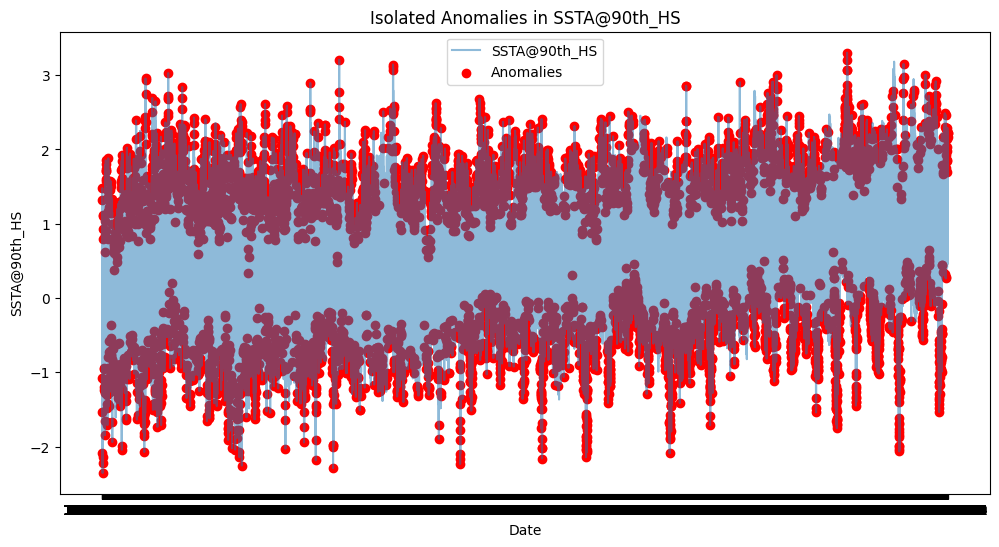

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(combined_regional_df.index, combined_regional_df['SSTA@90th_HS'], label='SSTA@90th_HS', alpha=0.5)
plt.scatter(combined_regional_df.index[combined_regional_df['SSTA_anomaly'] == 1],
            combined_regional_df['SSTA@90th_HS'][combined_regional_df['SSTA_anomaly'] == 1],
            color='red', label='Anomalies')
plt.title('Isolated Anomalies in SSTA@90th_HS')
plt.xlabel('Date')
plt.ylabel('SSTA@90th_HS')
plt.legend()
plt.show()

***Interpretation***

- **Red (Anomalies)**: The red dots represent the anomalies. There are several key takeaways from here that we will get into.

- **Light Blue Shade (Raw SSTA values)**: This simply just represents the raw data values as we saw from earlier. This is just makes it easier for us to see and sor t of intuitively makes sense to map on top of tha anomalies


***Takeaways***

There are a couple of key insights that I would like to point out here: clustering patterns, and a upward positive trend in recent years.

- **Anomaly Clusters**: As can be visually seen from the graph, we seem to see certain clusters of anomalies, this indicates to us that the there could actually be patterns and trends for anomalies during certain periods. This is crucial knowledge for our model

- **Upward Trend**: We can also deduce from the graph that there seems to also be an upward trend in the anomalies throughout the time-period where we see that the temperature is actually indeed increasing the most recent years.

- **Volatile Anomalies**: Lastly, if we look closely, we can see that there are some anomaly volatility over time. To put it more clear, we can see that some years show much high anomaly spikes compared to others. This indicates to us that there likely was some years that imposed higher risks on bleaching severity levels compared to others.

***Conclusion***

What we conclude from this is that the SST anomalies seem to appear in cluster patterns, this would conclude that we might be able to detect future anomalies once we understand how these patterns occur. 

Not only that, but in the time line trend, we seem to see a gradual increase towards upper percentile SST anomalies. This indicates to use that there might be hidden driving factors to increased water temperature also hinting to further evidence of gradual climate change and SST temperature increase over a long period of time.

We also witnessed certain years having much more clusters of SST anomalies compared to others which made us questions what other factors could be making this effect. I would just like to take one more plot to visualise the concept that we just mention here:

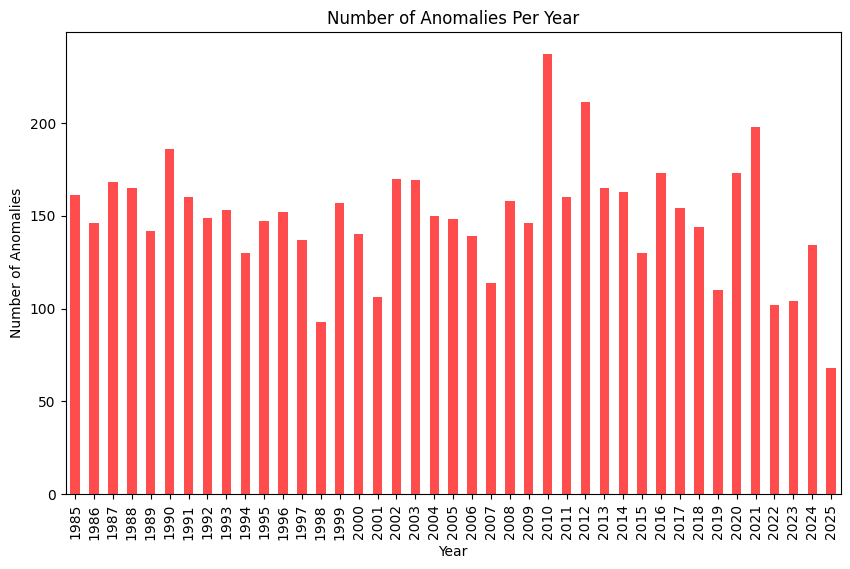

In [58]:
combined_regional_df.index = pd.to_datetime(combined_regional_df.index) 

combined_regional_df['Year'] = combined_regional_df.index.year
anomalies_per_year = combined_regional_df[combined_regional_df['SSTA_anomaly'] == 1].groupby('Year').size()

plt.figure(figsize=(10, 6))
anomalies_per_year.plot(kind='bar', color='red', alpha=0.7)
plt.title('Number of Anomalies Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Anomalies')
plt.show()

## Section 2: Feature Engineering

### Sub Sections:

- Sub-section 2.1: Defining & Implementing Features

### Sub-Section 2.1: Defining & Implementing Features

The chosen features that we will be working with and engineering from are as follows:

- **Rolling Mean and Standard Deviation**: As covered in our previous section and actually already defined in ur dataframe, we will be using the rolling mean and SD from the rolling analysis that we did.

- **Year**: We are adding a Year column to the dataframe in order to do some grouping by year, because we witnessed that some years had more anomaly clusters and it made sense to do a year by year analysis.

- **Time Lags from EDA 1**: Exactly what we concluded and included in our first NOAA EDA from the higher level time-series analysis, we will want to be including the same time lag features here again as that will come in handy for anomaly detection

In [59]:
print(combined_regional_df.columns)

Index(['YYYY', 'MM', 'DD', 'SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS',
       '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max', 'Station', 'Region',
       'Latitude', 'Longitude', 'Season', 'SSTA_rolling_mean',
       'SSTA_rolling_std', 'SSTA_anomaly', 'Year'],
      dtype='object')


As we can confirm from the print above, we already have the necessary feature columns for the rolling mean, rolling SD, and year. The only feature variables that we are missing are the time lags. Since we have already done this in notebook 1, let us just quickly copy and past them back to here. 

We can bring all of them over except for the DHW and the 90th_HS threshold time lags. We don't want these because we are just trying to detect the anomaly patterns and it might introduce the risk of overfitting as they are measuring threshold values rather than SST values:

In [60]:
combined_regional_df['SST_MIN_lag_back_4'] = combined_regional_df['SST_MIN'].shift(-4)
combined_regional_df['SST_MAX_lag_back_4'] = combined_regional_df['SST_MAX'].shift(-4)
combined_regional_df['SST@90th_HS_lag_back_4'] = combined_regional_df['SST@90th_HS'].shift(-4)
combined_regional_df['SSTA@90th_HS_lag_back_3'] = combined_regional_df['SSTA@90th_HS'].shift(-3)

Do one last NaN drop to just to be sure we have a clean set after introducing new time lags:

In [61]:
combined_regional_df = combined_regional_df.dropna()

print(combined_regional_df[['SST_MIN_lag_back_4', 'SST_MAX_lag_back_4', 'SST@90th_HS_lag_back_4', 'SSTA@90th_HS_lag_back_3']].head())

            SST_MIN_lag_back_4  SST_MAX_lag_back_4  SST@90th_HS_lag_back_4  \
Date                                                                         
1985-01-03               24.06               24.77                   24.63   
1985-01-03               26.07               26.74                   26.57   
1985-01-03               28.80               29.27                   29.03   
1985-01-03               25.69               26.60                   26.52   
1985-01-03               23.48               24.20                   24.06   

            SSTA@90th_HS_lag_back_3  
Date                                 
1985-01-03                   0.1529  
1985-01-03                  -0.3471  
1985-01-03                  -0.6484  
1985-01-03                   0.7219  
1985-01-03                  -0.8406  


Lastly, we will need to just setup a scaled features variable. Ofcourse as we in the unsupervised learning realm, we will not need to be doing any data splits. We just need to define the features that we are working with as already known from above and scale them along with the other values. 

Let us just do a quick re-check now of all values, decide what to drop, then scale the rest

In [62]:
print('Columns in the dataset:', combined_regional_df.head())

Columns in the dataset:             YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  \
Date                                                                    
1985-01-03  1985   1   3    25.88    27.98        27.78        0.3132   
1985-01-03  1985   1   3    26.85    27.08        26.98       -0.2174   
1985-01-03  1985   1   3    26.09    26.67        26.63       -0.5723   
1985-01-03  1985   1   3    28.24    29.01        28.92        0.1529   
1985-01-03  1985   1   3    24.06    24.77        24.63       -0.3471   

            90th_HS>0  DHW_from_90th_HS>1  BAA_7day_max  ... Longitude  \
Date                                                     ...             
1985-01-03        0.0                 0.0             0  ...  -163.625   
1985-01-03        0.0                 0.0             0  ...    81.575   
1985-01-03        0.0                 0.0             0  ...   -78.700   
1985-01-03        0.0                 0.0             0  ...  -170.475   
1985-01-03        0.

Drop the columns and confirm we are working with only needed values: 

In [63]:
columns_to_drop = ['Latitude', 'Longitude', '90th_HS>0', 'DHW_from_90th_HS>1', 'Season'] 
combined_regional_df = combined_regional_df.drop(columns=columns_to_drop)

print(combined_regional_df.columns)

Index(['YYYY', 'MM', 'DD', 'SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS',
       'BAA_7day_max', 'Station', 'Region', 'SSTA_rolling_mean',
       'SSTA_rolling_std', 'SSTA_anomaly', 'Year', 'SST_MIN_lag_back_4',
       'SST_MAX_lag_back_4', 'SST@90th_HS_lag_back_4',
       'SSTA@90th_HS_lag_back_3'],
      dtype='object')


Everything seems in order, now scale the values:

In [64]:
columns_to_scale=['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', 'SSTA_rolling_mean', 
          'SSTA_rolling_std', 'SST_MIN_lag_back_4', 'SST_MAX_lag_back_4', 
          'SST@90th_HS_lag_back_4', 'SSTA@90th_HS_lag_back_3']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_regional_df[columns_to_scale])

## Section 3: Unsupervised Model Analysis

This has put us in a great spot to begin experimenting with some unsupervised models and have an attempt at some unsupervised learnings in order to capture anomaly detections

### Sub Sections:

- Sub-section 3.1: K-Means For Anomaly Detection

- Sub-Section 3.2: DBSCAN for Anomaly Detection (True Outliers)

- Subsection 3.3: Isolation Forest for Anomaly Detection

- Subsection 3.4

### Sub-Section 3.1: K-Means & Cluster Optimisation

Within this sub-section we will cover our first attempt at detecting SST anomaly patterns, we are going to being with using the unsupervised K-Means clustering method where we shall plot begin with a default cluster grouping of 3, then work our way up by trying to find optimised points.

***What is K-MEANS?***

The K-Means in a unsupervised learning approach where we we **pre-define** a number of clusters where our program will iterate thhrough the scaled features from above and determine the best cluster grouping of the SST anomalies.

***How does the algorithm operate***

The K-Means algorithm will start by plotting three random points for the clustering which we call the centroid. THe number of centroids are determine by K which equals the number of clusters that we have set to 3. 

Once the algorithm has plotted three of the centroids randomly, it will begin to calculate the distance between **each** datapoint the centroid, ofcourse lets say that we have three centroids and we have datapoint 1, once the distance is calculated for each of the 3 distances between the datapoint and the centroid, the algorithm is able to determine which value out of the three has the lowest distance. Based on that value, the lowest distance is classified as the "winner" and is grouped in the same category/cluster as that centroid. The algorithm will repeat this process until it completes for all datapoints to each 3 centroid.

Once we have the datapoint categorised, the algorithm will then calculate the mean of those 3 clusters, Once the algorith, has the mean value for each of those clusters, it is going to replot the centroids in accordance to those means and repeat the same process all over again. This is how the algorithm actually determines the optimal clustering for the specified K and the data features that it receives. 

Let's have a go:

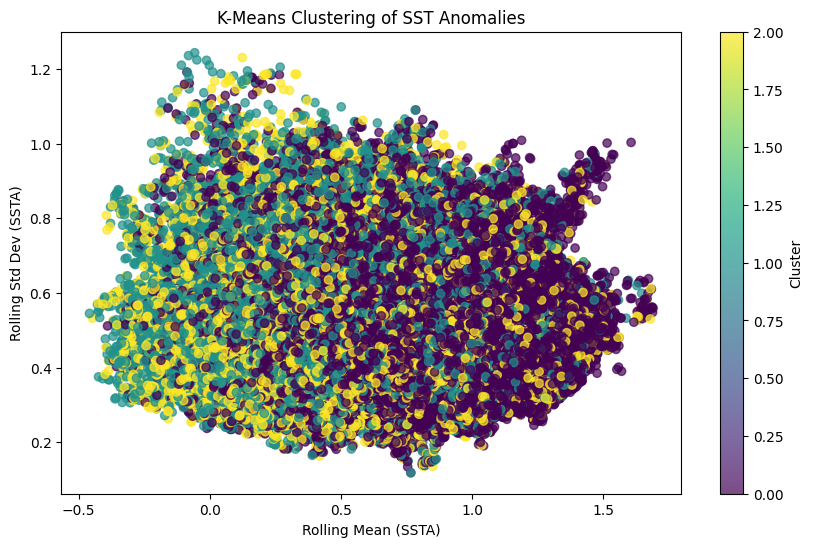

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42) 
combined_regional_df['Cluster_KMeans'] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(combined_regional_df['SSTA_rolling_mean'], combined_regional_df['SSTA_rolling_std'], 
            c=combined_regional_df['Cluster_KMeans'], cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering of SST Anomalies')
plt.xlabel('Rolling Mean (SSTA)')
plt.ylabel('Rolling Std Dev (SSTA)')
plt.colorbar(label='Cluster')
plt.show()

***Interpretation***

This is great. We can see a clear distinction between the clusters where we see the cluster 0 for purple showing a higher rolling mean for the SSTA, and the cluster 2 (yellow) shows us a lower rolling mean score. 

Something very important to note here as this can be confusing at first look, the range scale on the right for the clusters are **arbitrary**! They do not directly associate with any SST values and is ONLY for the purpose of the K-Means clustering.

This basically tells us that the K-Means model has managed to successfully detect and display the anomaly temperatures against the rolling mean where the purple mostly scores in the upper percentile and the yellow in the lower. 

The upper percentile of the rolling mean > 0.5 indicates **sustained warm temperature anomalies**, while the lower percentile displays **sustained cooler temperature anomalies** as mainly dominated by the yellow region. The green likely shows us the transitions periods between the two anomalies.

As already know from and concluded from our first notebook, we detected that warmer SST temperatures lead to increase bleaching risk, so we can hypothesis at this point that these anomaly detections in the higher rolling meaning we could:

1. Say that they cause for concern and where in fact related to bleaching severity

2. Know where to put more weight in decision making for the SST anomalies in our original RFR and try to leverage for increased accuracy

### Cluster Optimisation 

We just chose a default value of 3 for K as that seemed to be the standard when working with K-Means and we where desperate to get a first look at the anomaly data, but this is not complete and is simply not good enough. 

There are actually techniques that we can use in order to find the optimal K value, but before we get into it allow me to explain the concept:

Let's say we have a scenario that we set the K = 1, then we would not have any clustered data to compare ofcourse. We can say here that this means the variance will then equate to 0. The variance is the calculated distribution of these clustered results. Now if we set K = 2 then we would have 2 clusters to compare.

Now when we compare those 2 clusters we might see the variance to actually favour 1 cluster much more over the other. This happens because the K-Means algorithm calculated and grouped optimally for the distance to the centroid mean as it is supposed to do according to the spread which happened to determine that one cluster was to have many more data points than the other.

Now we apply this concept to K = 3 and we see the same thing. Now, there is an optimal cluster which can be determined. This is when the ***variance is as close as it can be to a equal distribution***. Once we can determine that, we will be able to see what the optimal K value, number of clusters is.

In code terms, we can actually use what we call an Elbow Method in order to determine this and leverage the inertia value:

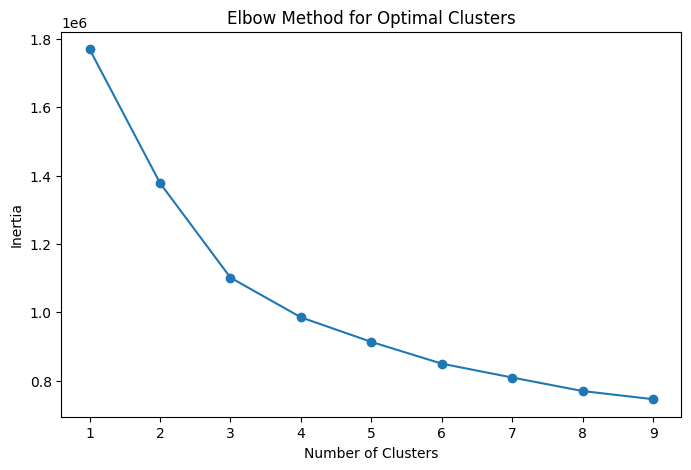

In [72]:
inertias = []

for k in range(1, 10):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertias, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

***Inertia***

The Inertia here is calulcated by the sum of the squared distances to the nearest centroid

***Takeaway***

Here we are looking for the inertia value that shows us where adding more clusters does not reduce the inertia value by a lot. 

From the visual presentation, it is clear that the optimal cluster value can be said that we where already on the money with 3 clusters. There is another lengthy check that we can do called the silhoutte scores from sklearns metrics that will allow us to conclude with a final answer:

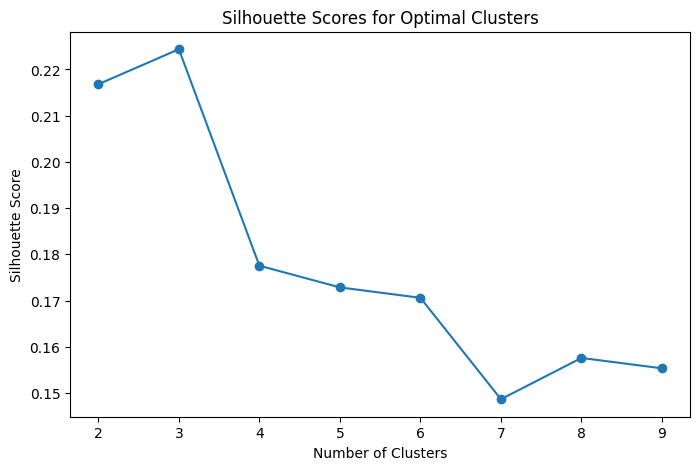

In [ ]:
silhouette_scores = []

for k in range(2, 10): 
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

***Verdict***

The final verdict shows a K (number of clusters) value of 3 to be optimal with the highest silhoutte score of what looks to be approximately 0.228. We can now be rested and ensure that our original K-Means model was giving us the best anomaly detection results. 

### Sub-section 3.2: DBSCAN For Anomaly Detection (True Outliers)

Within this sub-section, we will be attempting to map the anomaly detection again but rather with the DBSCAN algorithm, also known as: Density Based Spatial Clustering of an Application with Noise.

Before we get into the modelling and iteration, lets quickly cover why we want to do this. When do cluster analysis with K-Means, the key point is that the algorithm will actually assign every data point to a cluster as we saw (purple, green, yellow). The things is that this means even outlier values are always put into group making it a sort of forced clustering pattern if I may.

On the other hand, with the DBSCAN algorithm, we are actually trying to find the points that are outliers and do the opposite of the for fitting. We could say that it is programmed to actually look for these outliers. In this algorithm this is what we call noise and you will see under the label of -1:

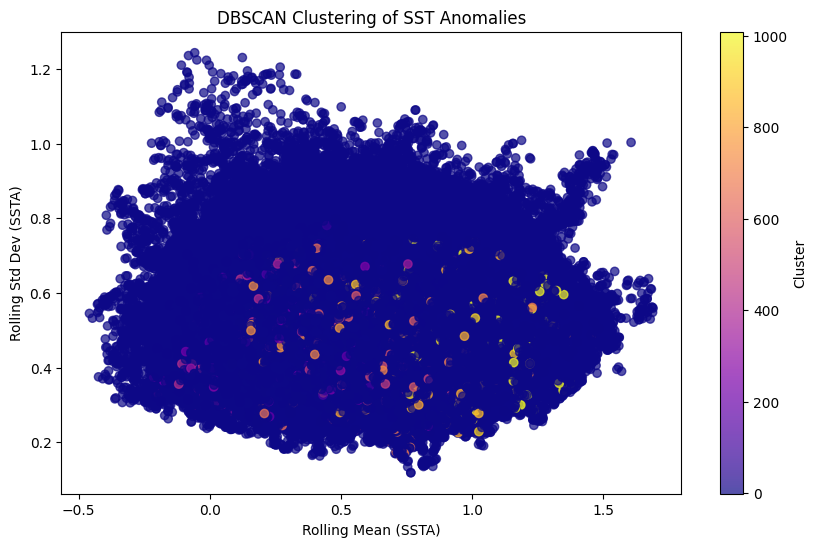

In [79]:
dbscan = DBSCAN(eps=0.5, min_samples=5) 
combined_regional_df['Cluster_DBSCAN'] = dbscan.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(combined_regional_df['SSTA_rolling_mean'], combined_regional_df['SSTA_rolling_std'], 
            c=combined_regional_df['Cluster_DBSCAN'], cmap='plasma', alpha=0.7)
plt.title('DBSCAN Clustering of SST Anomalies')
plt.xlabel('Rolling Mean (SSTA)')
plt.ylabel('Rolling Std Dev (SSTA)')
plt.colorbar(label='Cluster')
plt.show()

***Visual Interpretation***

As we can see, the majority of the diagram being clouded by the blue area represents the density region. There are the SST anomaly patterns which are not out of the ordinary and do not fall into the category of outliers.

For the remained of where we can see spots ranging from purple to yellow, these are what we are interested in. These can be seen as the outliers where the closer we get to the colour yellow the anomaly is detected to be a more significant outlier.

Ofcourse since the DBSCAN did the outlier clustering for us, we can look solely to those values and have a quick look at those outlier datapoints:

In [81]:
print(combined_regional_df[combined_regional_df['Cluster_DBSCAN'] == -1])

            YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  \
Date                                                                    
1985-01-03  1985   1   3    25.88    27.98        27.78        0.3132   
1985-01-03  1985   1   3    26.85    27.08        26.98       -0.2174   
1985-01-03  1985   1   3    26.09    26.67        26.63       -0.5723   
1985-01-03  1985   1   3    24.06    24.77        24.63       -0.3471   
1985-01-03  1985   1   3    28.80    29.27        29.03        0.7219   
...          ...  ..  ..      ...      ...          ...           ...   
2025-05-24  2025   5  24    29.91    30.88        30.76        0.9487   
2025-05-24  2025   5  24    28.42    29.96        29.44        1.3532   
2025-05-24  2025   5  24    28.33    29.81        29.09        1.3110   
2025-05-24  2025   5  24    25.11    27.49        27.08        1.3084   
2025-05-24  2025   5  24    28.94    30.33        30.27        1.1774   

            BAA_7day_max                Station   

***Conclusion***

As a conclusion, we can say clearly from this visual representation that the DBSCAN returns a **single dominant clustering pattern** generalising well to our anomaly data but also clearly indicates the presences of outliers that we might want ot further investigate and leverage within our supervise RFR model.

### Sub-section 3.3: Isolation Forest

In this sub-section, we will be doing our last model trying to detect anomaly behviours using the **Isolation Forest** algorithm.

***Why did we select this model***

In our previous two models, we where basically able to use the K-Means in order to cluster the datapoints for the anomaly patterns, used DBSCAN for specifically detecting anomaly outliers. Here with the Isolation Forest, we hope to do the task of **isolating anomalies**. What we mean by isolation here is to basically split a certain datapoint from the rest

Isolation Forest basically works by building many random trees (similar to random forest) that split the data based on **randomly** selected values. Points that are isolated quickly are more likely to be anomalies. I.e. that require less line draw around them to box them off the other values.

This actually makes it so computationally fast and uses much less RAM because it just directly gives each of these datapoints an anomaly score. As tested, they are also seen to work quite well on large datasets which is not too surprising due to their low computation resource requirements.

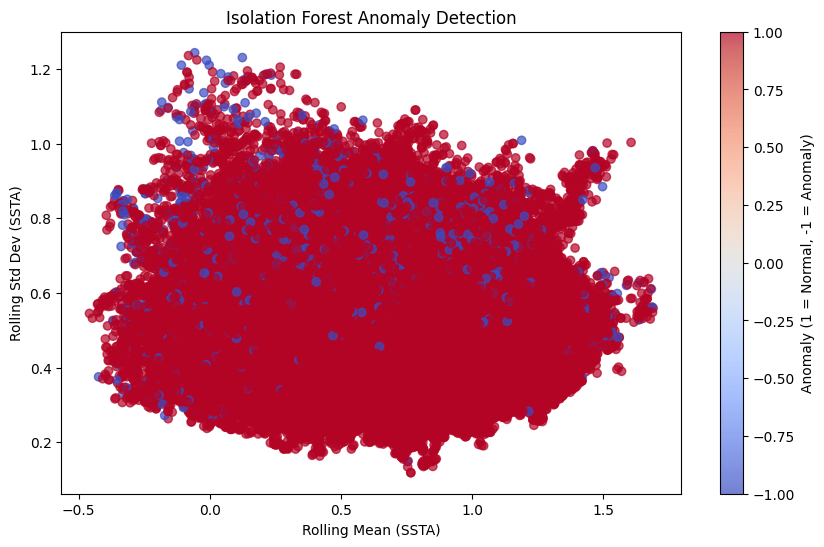

In [ ]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)  
combined_regional_df['Anomaly_IsoForest'] = iso_forest.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(combined_regional_df['SSTA_rolling_mean'], combined_regional_df['SSTA_rolling_std'], 
            c=combined_regional_df['Anomaly_IF'], cmap='coolwarm', alpha=0.7)
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Rolling Mean (SSTA)')
plt.ylabel('Rolling Std Dev (SSTA)')
plt.colorbar(label='Anomaly (1 = Normal, -1 = Anomaly)')
plt.show()

***Interpretation***

Just to define upfront what the colour coding means for us here:

- **Red: (1)**: These datapoints are the normal datapoint (inlier) as recognised by the Isolation Forest model.

- **Blue: (-1)**: These are the outlier/anomaly datapoints that are recognised the Isolation Forest model. 

Working from this knowledge now, we can clearly say that our graph represents a likely realistic view to our dataset. We see many less outliers in comparison to the inliers. 

One more interesting observation that can be taken from this is that we seem to see more anomalies the closer we get to the upper percentile of the rolling standard deviation. This can likely be explained by the increased spread and volatility of these anomalies and generally aligns with the definition of anomaly